# Prediction for Berlin

## Summary writing is in README.md

In [1]:
import os
import sys
import warnings

import numpy as np

import pandas as pd
import statsmodels.formula.api as smf
from IPython.core.display import HTML
import seaborn as sns

warnings.filterwarnings("ignore")
from plotnine import ggplot, aes, geom_point, labs, scale_x_continuous, scale_y_continuous, theme_bw
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from mizani.formatters import percent_format

In [2]:
df = pd.read_csv('Münich.csv')
print(df.shape)         # (13984, 75)
df.head()              # Show first 3 rows as a sample

(10856, 75)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,30536,https://www.airbnb.com/rooms/30536,20241220045218,2024-12-20,city scrape,cosy room to let in naples,Oriental decorated apartment with wonderful te...,"Centrally located,close to public transport, i...",https://a0.muscache.com/pictures/171280/92fe69...,14169118,...,4.78,4.44,4.56,NaN,f,7,1,6,0,0.11
1,63413,https://www.airbnb.com/rooms/63413,20241220045218,2024-12-20,city scrape,Charming Room on Riviera di Chiaia,Centrally located and at walking distance to t...,The house is located in a lively and popular n...,https://a0.muscache.com/pictures/389538/99361e...,309483,...,4.82,4.73,4.66,NaN,f,1,1,0,0,0.93
2,74364,https://www.airbnb.com/rooms/74364,20241220045218,2024-12-20,city scrape,Cozy place in a princely Palace inside Old Town,A really cozy studio (24 square meters) in a p...,The flat is in the OLD TOWN od Napoli with 2 m...,https://a0.muscache.com/pictures/c8a48f3d-1be3...,289412,...,4.97,4.83,4.88,NaN,f,4,4,0,0,1.70
3,76993,https://www.airbnb.com/rooms/76993,20241220045218,2024-12-20,city scrape,"Central Cebollitas B&B, spacious private ensuite.","A bright, sunny home in vomero area (on a hill...","La casa di Cebollitas si trova a Napoli, Campa...",https://a0.muscache.com/pictures/miso/Hosting-...,411650,...,4.99,4.93,4.94,IT063049C1J5MLGK7O,f,4,1,3,0,0.54
4,77009,https://www.airbnb.com/rooms/77009,20241220045218,2024-12-20,city scrape,"Central Cebollitas B&B Napoli,single/double room",NaN,"La casa di Cebollitas si trova a Napoli, Campa...",https://a0.muscache.com/pictures/airflow/Hosti...,411650,...,4.96,4.86,4.87,IT063049C1J5MLGK7O,f,4,1,3,0,1.25


## Cleaning the Data

In [3]:
# Drop rows where 'price' is NaN
df = df.dropna(subset=['price'])
print(df.shape)  # Now (8990, 75), after removing rows with missing price

(9941, 75)


In [4]:
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.replace("'", "_")

In [5]:
# Drop columns with > 3000 missing values
cols_to_drop = ['calendar_updated', 'host_neighbourhood', 'neighborhood_overview', 'neighbourhood', 'host_about']
df = df.drop(columns=cols_to_drop)
print(df.shape)  # e.g., (8990, 70) after dropping high-missing columns

(9941, 70)


In [6]:
if 'review_scores_rating' in df.columns:
    df['flag_review_scores_rating'] = df['review_scores_rating'].isna().astype(int)
else:
    print("Column 'review_scores_rating' not found; skipping flag_review_scores_rating.")

In [7]:
if 'last_review' in df.columns:
    df['flag_days_since'] = df['last_review'].isna().astype(int)
else:
    print("Column 'last_review' not found; skipping flag_review_scores_rating.")

In [8]:

if 'last_review' in df.columns:
    df['flag_reviews_per_month'] = df['reviews_per_month'].isna().astype(int)
else:
    print("Column 'reviews_per_month' not found; skipping flag_review_scores_rating.")

In [9]:
import ast
# Parse the amenities string into a Python list for each listing
df['amenities_list'] = df['amenities'].apply(lambda x: ast.literal_eval(x))

# Define amenity groups and keywords for grouping
amenity_groups = {
    'internet': ['wifi', 'ethernet', 'wlan', 'internet'],
    'air_conditioning': ['air conditioning', 'air conditioner'],
    'heating': ['heating', 'fireplace'],
    'kitchen': ['kitchen', 'kitchenette', 'stove', 'oven', 'microwave', 'refrigerator', 'cooking basics'],
    'parking': ['parking'],
    'laundry': ['washer', 'laundromat', 'dryer'],
    'tv': ['tv'], 
    'elevator': ['elevator'],
    'pets': ['pet', 'dog', 'cat'],
    'family': ['child', 'children', 'crib', 'kid', 'high chair', 'stroller', 'baby'],
    'safety': ['smoke alarm', 'carbon monoxide', 'fire extinguisher', 'first aid']
}

# Create a dummy column for each amenity group
for group, keywords in amenity_groups.items():
    df[f'amenity_{group}'] = df['amenities_list'].apply(
        lambda amenities: 1 if any(any(k in amen.lower() for k in keywords) for amen in amenities) else 0
    )

# Drop the original amenities columns as we now have encoded dummies
df = df.drop(columns=['amenities', 'amenities_list'])

In [10]:
# Create dummy variables for neighbourhood_group_cleansed
neighborhood_dummies = pd.get_dummies(df['neighbourhood_cleansed'], 
                                        prefix='neighbourhood', 
                                        drop_first=True)
neighborhood_dummies = neighborhood_dummies.astype(int)

# Clean the column names: replace spaces and hyphens with underscores
neighborhood_dummies.columns = [col.replace(" ", "_").replace("-", "_") for col in neighborhood_dummies.columns]

# Merge the dummy columns into the main DataFrame and drop the original column
df = pd.concat([df, neighborhood_dummies], axis=1)

# Check the first few rows to confirm the new dummy columns
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,picture_url,host_id,host_url,...,neighbourhood_San_Giuseppe,neighbourhood_San_Lorenzo,neighbourhood_San_Pietro_a_Patierno,neighbourhood_Scampia,neighbourhood_Secondigliano,neighbourhood_Soccavo,neighbourhood_Stella,neighbourhood_Vicaria,neighbourhood_Vomero,neighbourhood_Zona_Industriale
0,30536,https://www.airbnb.com/rooms/30536,20241220045218,2024-12-20,city scrape,cosy room to let in naples,Oriental decorated apartment with wonderful te...,https://a0.muscache.com/pictures/171280/92fe69...,14169118,https://www.airbnb.com/users/show/14169118,...,0,1,0,0,0,0,0,0,0,0
1,63413,https://www.airbnb.com/rooms/63413,20241220045218,2024-12-20,city scrape,Charming Room on Riviera di Chiaia,Centrally located and at walking distance to t...,https://a0.muscache.com/pictures/389538/99361e...,309483,https://www.airbnb.com/users/show/309483,...,0,0,0,0,0,0,0,0,0,0
2,74364,https://www.airbnb.com/rooms/74364,20241220045218,2024-12-20,city scrape,Cozy place in a princely Palace inside Old Town,A really cozy studio (24 square meters) in a p...,https://a0.muscache.com/pictures/c8a48f3d-1be3...,289412,https://www.airbnb.com/users/show/289412,...,1,0,0,0,0,0,0,0,0,0
3,76993,https://www.airbnb.com/rooms/76993,20241220045218,2024-12-20,city scrape,"Central Cebollitas B&B, spacious private ensuite.","A bright, sunny home in vomero area (on a hill...",https://a0.muscache.com/pictures/miso/Hosting-...,411650,https://www.airbnb.com/users/show/411650,...,0,0,0,0,0,0,0,0,1,0
4,77009,https://www.airbnb.com/rooms/77009,20241220045218,2024-12-20,city scrape,"Central Cebollitas B&B Napoli,single/double room",NaN,https://a0.muscache.com/pictures/airflow/Hosti...,411650,https://www.airbnb.com/users/show/411650,...,0,0,0,0,0,0,0,0,1,0


In [11]:
# Fill missing values in beds, bathrooms, bedrooms with the mean of that column
for col in ['beds', 'bathrooms', 'bedrooms']:
    df[col] = df[col].fillna(df[col].mean())

In [12]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [13]:
df["price"] = pd.to_numeric(df["price"])

In [14]:
# Remove spaces and hyphens from all column names
df = df.rename(columns=lambda x: x.replace(" ", "_").replace("-", "_"))

# Also remove hyphens from the values in the 'neighbourhood_cleansed' column
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.replace("-", "_")

## descriptive statistics

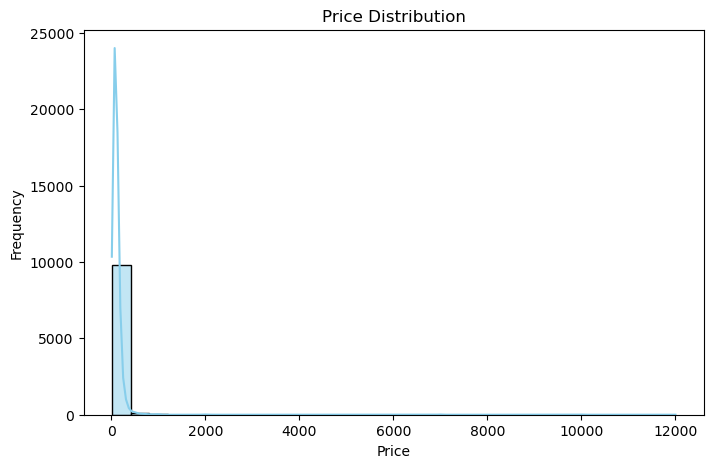

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=30, kde=True, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

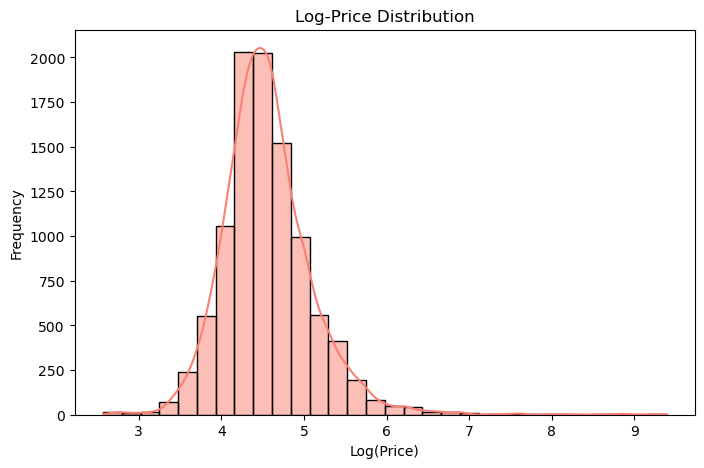

In [16]:
df['lnprice'] = np.log(df['price'])

plt.figure(figsize=(8, 5))
sns.histplot(df['lnprice'], bins=30, kde=True, color='salmon')
plt.title('Log-Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()

In [17]:
df = df[df['price'] <= 4000]

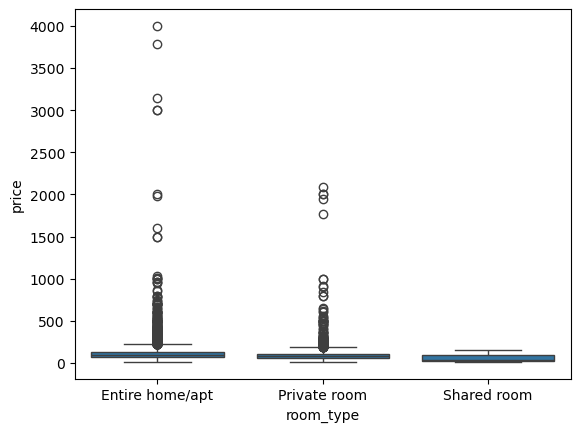

In [18]:
sns.boxplot(data = df, x = 'room_type', y = 'price', orient = 'v', order = ['Entire home/apt', 'Private room', 'Shared room'])
plt.show()


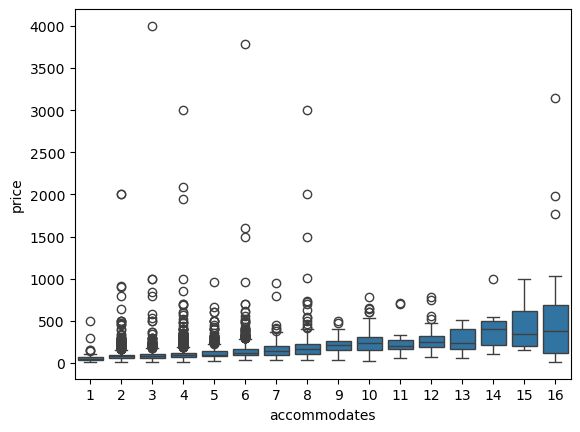

In [19]:
sns.boxplot(data = df, x = 'accommodates', y = 'price', orient = 'v')
plt.show()

In [20]:
all_property_types = sorted(df['property_type'].unique())
all_room_types = sorted(df['room_type'].unique())

# Convert the columns to categorical with these explicit levels
df['property_type'] = pd.Categorical(df['property_type'], categories=all_property_types)
df['room_type'] = pd.Categorical(df['room_type'], categories=all_room_types)

In [21]:
to_filter=df.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

neighbourhood_group_cleansed    9930
license                         4365
host_location                   3134
review_scores_checkin           2354
review_scores_cleanliness       2354
review_scores_accuracy          2354
last_review                     2353
review_scores_rating            2353
review_scores_value             2353
review_scores_location          2353
review_scores_communication     2353
reviews_per_month               2353
first_review                    2353
host_response_rate              1899
host_response_time              1899
host_acceptance_rate            1123
host_is_superhost                291
description                      212
has_availability                  35
bathrooms_text                    13
dtype: int64

In [22]:
df.host_is_superhost = df.host_is_superhost.fillna('f')

In [23]:
df['host_is_superhost'] = df['host_is_superhost'].map({'f': 0, 't': 1})

In [24]:
# Factorize the host_response_time column (missing values are coded as -1)
codes, uniques = pd.factorize(df['host_response_time'])
df['host_response_time'] = codes

# Calculate the mean of the valid codes (excluding -1)
valid_mean = df.loc[df['host_response_time'] != -1, 'host_response_time'].mean()

# Replace missing values (coded as -1) with the computed mean
df.loc[df['host_response_time'] == -1, 'host_response_time'] = valid_mean

# Display the first few rows to verify the changes
df[['host_response_time', 'host_response_time']].head()

,host_response_time,host_response_time
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [25]:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype(float)

In [26]:
df = df.fillna(df.mean(numeric_only=True))

In [27]:
df['host_has_profile_pic'] = df['host_has_profile_pic'].map({'f': 0, 't': 1})
df['host_identity_verified'] = df['host_identity_verified'].map({'f': 0, 't': 1})

In [28]:
df['last_review'] = pd.to_datetime(df['last_review'], format="%Y-%m-%d", errors='coerce')

# Find the latest date in the 'last_review' column
latest_date = df['last_review'].max()

# Create n_days_since: days between the latest date and each last_review date (min value becomes 0)
df['n_days_since'] = (latest_date - df['last_review']).dt.days

# Create n_accommodates2: 1 if 'accommodates' equals 2, else 0
df['n_accommodates2'] = (df['accommodates'] == 2).astype(int)

# Create n_days_since2: 1 if n_days_since equals 2, else 0
df['n_days_since2'] = (df['n_days_since'] == 2).astype(int)

# Create n_days_since3: 1 if n_days_since equals 3, else 0
df['n_days_since3'] = (df['n_days_since'] == 3).astype(int)

### Finding Interactions

In [29]:
basic_lev = (
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "n_days_since",
    "flag_days_since"
)
basic_add = ("bathrooms", "bedrooms", "host_is_superhost", "flag_reviews_per_month")
reviews = ("number_of_reviews", "review_scores_rating", "flag_review_scores_rating", "reviews_per_month")
host = ("host_response_time", "host_response_rate", "host_acceptance_rate", "host_has_profile_pic", "host_identity_verified")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3", "host_acceptance_rate")

In [30]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()
    
    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))
        
        # Adjust x positions for dodge effect
        if i == 1:
            x = x + 0.2
        else:
            x = x - 0.2
            
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')
    
    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )
    
    # Remove grid
    ax.grid(False)
    plt.show()
    
    return plt



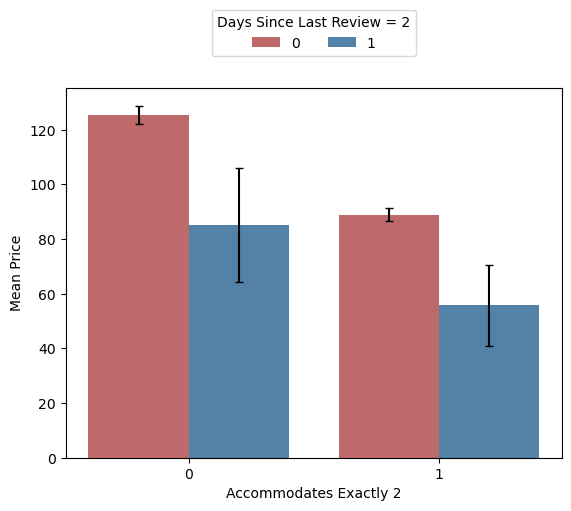

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [31]:
price_diff_by_variables(df, factor_var="n_accommodates2", dummy_var="n_days_since2", factor_lab="Accommodates Exactly 2", dummy_lab="Days Since Last Review = 2")

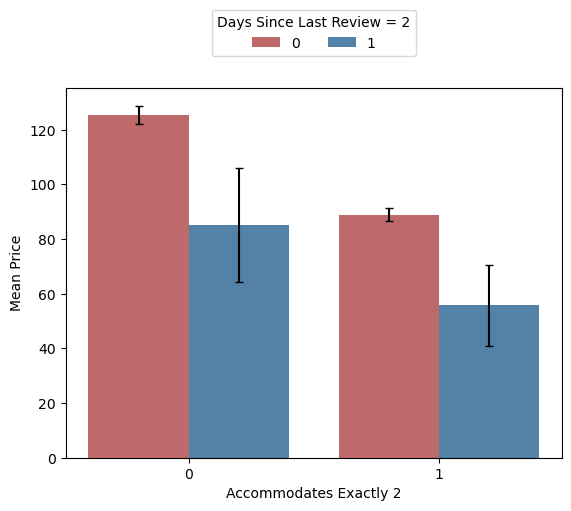

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [32]:
price_diff_by_variables(
    df=df,
    factor_var="n_accommodates2", 
    dummy_var="n_days_since2",
    factor_lab="Accommodates Exactly 2",
    dummy_lab="Days Since Last Review = 2"
)


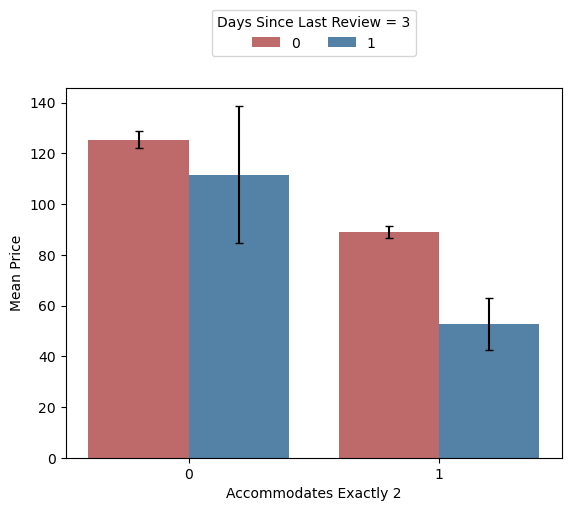

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [33]:
price_diff_by_variables(
    df=df,
    factor_var="n_accommodates2", 
    dummy_var="n_days_since3",
    factor_lab="Accommodates Exactly 2",
    dummy_lab="Days Since Last Review = 3"
)

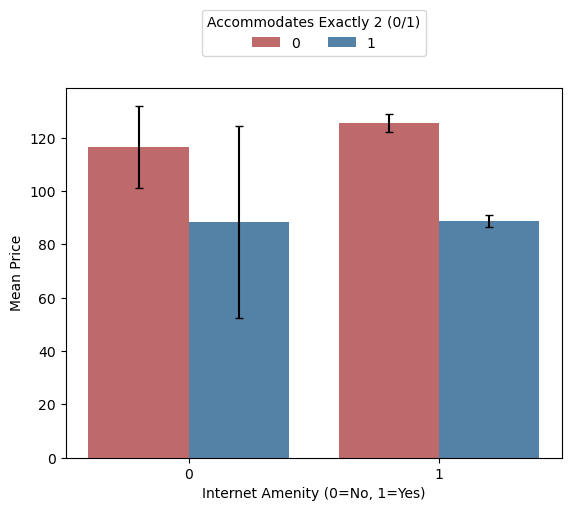

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [34]:
price_diff_by_variables(
    df=df,
    factor_var="amenity_internet",       # 0: No internet, 1: Internet available
    dummy_var="n_accommodates2",          # 0: Not exactly 2, 1: Exactly 2
    factor_lab="Internet Amenity (0=No, 1=Yes)",
    dummy_lab="Accommodates Exactly 2 (0/1)"
)


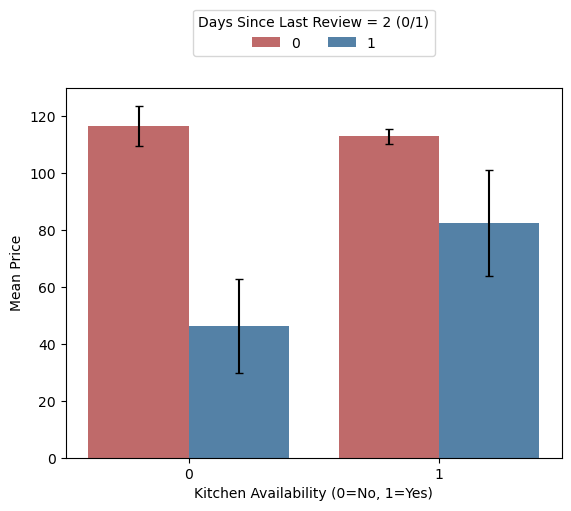

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [35]:
price_diff_by_variables(
    df=df,
    factor_var="amenity_kitchen",         # 0: No kitchen, 1: Kitchen available
    dummy_var="n_days_since2",              # 0: n_days_since is not 2, 1: n_days_since equals 2
    factor_lab="Kitchen Availability (0=No, 1=Yes)",
    dummy_lab="Days Since Last Review = 2 (0/1)"
)

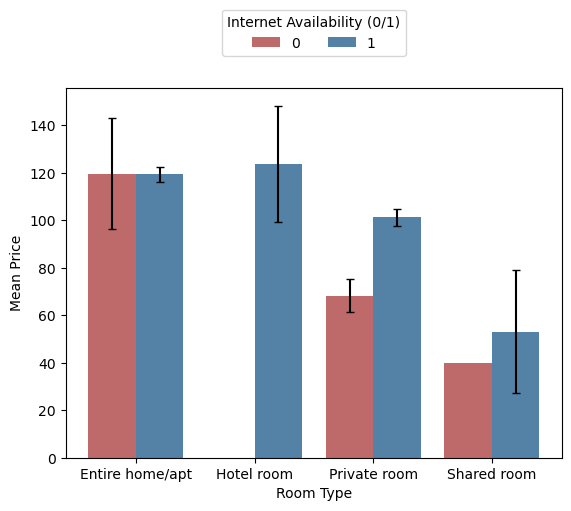

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [36]:
price_diff_by_variables(
    df=df,
    factor_var="room_type",              # Categorical variable: Room Type
    dummy_var="amenity_internet",        # Binary variable: Internet Availability (0 = No, 1 = Yes)
    factor_lab="Room Type",
    dummy_lab="Internet Availability (0/1)"
)

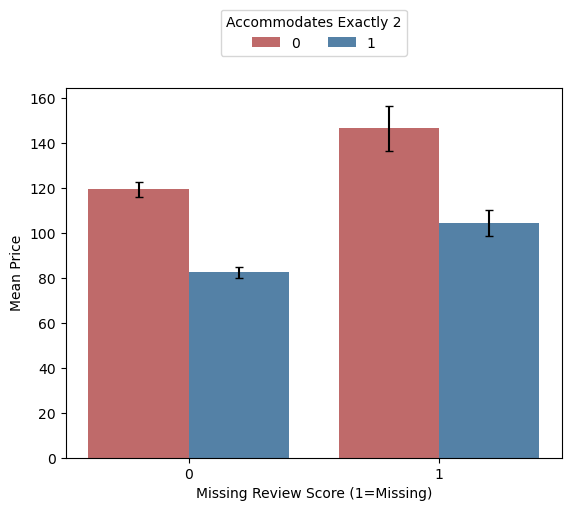

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [37]:
price_diff_by_variables(
    df=df,
    factor_var="flag_review_scores_rating", 
    dummy_var="n_accommodates2",
    factor_lab="Missing Review Score (1=Missing)",
    dummy_lab="Accommodates Exactly 2"
)

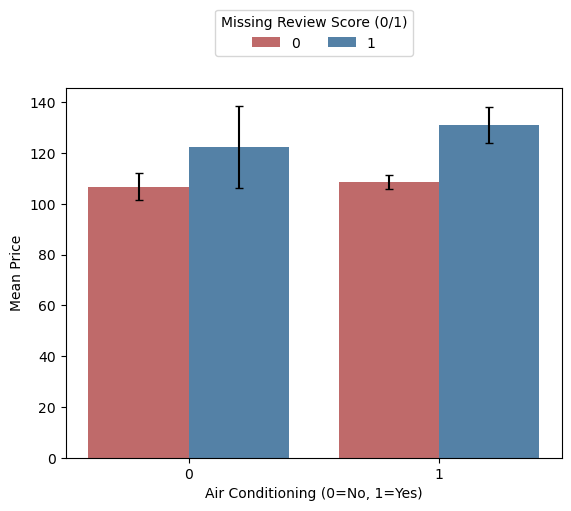

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [38]:
price_diff_by_variables(
    df=df,
    factor_var="amenity_air_conditioning",  # 0: No air conditioning, 1: Air conditioning available
    dummy_var="flag_review_scores_rating",    # 0: Review score available, 1: Review score missing
    factor_lab="Air Conditioning (0=No, 1=Yes)",
    dummy_lab="Missing Review Score (0/1)"
)

In [39]:
amenities = [col for col in df.columns if col.startswith("amenity_")]
print(amenities)

['amenity_internet', 'amenity_air_conditioning', 'amenity_heating', 'amenity_kitchen', 'amenity_parking', 'amenity_laundry', 'amenity_tv', 'amenity_elevator', 'amenity_pets', 'amenity_family', 'amenity_safety']


In [40]:
X1 = (
    "room_type*property_type",
    "room_type*amenity_family"
)

# X2: Interactions between property_type and selected amenity variables
X2 = (
    "amenity_air_conditioning*property_type",
    "amenity_pets*property_type"
)

# X3: A broad interaction between key categorical variables and all amenity variables.
# Since you do not have cancellation_policy, we use (property_type + room_type + bed_type)
X3 = "(property_type + room_type) * (" + " + ".join(amenities) + ")"

In [41]:
modellev1="~ accommodates"
modellev2="~"+"+".join(basic_lev)
modellev3="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)
modellev4="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)
modellev5="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)
modellev6="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)+"+"+"+".join(X2)
modellev7="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)
modellev8="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)+"+"+X3

In [42]:
smp_size = round(0.2 * df.shape[0])-1
smp_size

1985

## OLS prediction

In [43]:
np.random.seed(20250217)

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
df_train, df_holdout = train_test_split( df, train_size=0.7, random_state = 20250224)

In [46]:
df_train.shape

(6951, 117)

In [47]:
df_holdout.shape

(2979, 117)

In [48]:
n_folds=5

In [49]:
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [50]:
def cv_reg(formula, df, kfold, testdf, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(df):
        df_train, df_test = df.iloc[train_index, :], df.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data = df_train).fit()
        else:
            model = smf.ols(formula, data = df_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(df_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [df_train["price"], model.predict(df_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [df_test["price"], model.predict(df_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [51]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]:
    cv_list += [cv_reg("price" + i, df, k, "HC0")]

In [52]:
summarize_cv(cv_list).map('{:,.3f}'.format)

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
Fold1,113.983,91.819,88.705,87.569,87.500,87.086,86.890,85.571
Fold2,111.949,88.263,84.521,83.740,83.579,83.046,82.836,81.548
Fold3,119.481,104.071,100.800,100.092,100.029,99.386,99.195,98.153
Fold4,120.715,101.618,98.700,97.843,97.766,97.339,97.198,95.999
Fold5,109.202,93.600,90.114,89.188,89.093,88.682,88.503,87.294
Average,115.066,95.874,92.568,91.686,91.593,91.108,90.924,89.713


In [53]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
df_rmse_levels = pd.DataFrame.from_dict(rmse_levels)
df_rmse_levels["nvars2"] = df_rmse_levels["nvars"] + 1

In [54]:
df_rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,1.150661e+02,2
1,49,RMSE Training,9.587402e+01,50
2,60,RMSE Training,9.256816e+01,61
3,91,RMSE Training,9.168640e+01,92
4,96,RMSE Training,9.159349e+01,97
5,152,RMSE Training,9.110784e+01,153
6,160,RMSE Training,9.092442e+01,161
7,315,RMSE Training,8.971277e+01,316
8,1,RMSE Test,1.137849e+02,2
9,49,RMSE Test,9.472289e+01,50


In [55]:
model2_train_rmse = pd.Series(cv_list[2]["rmse"]).mean()
model2_test_rmse = pd.Series(cv_list[2]["rmse_test"]).mean()

print("Model 3 RMSE Training: {:.3f}".format(model2_train_rmse))
print("Model 3 RMSE Test: {:.3f}".format(model2_test_rmse))

Model 3 RMSE Training: 92.568
Model 3 RMSE Test: 91.396


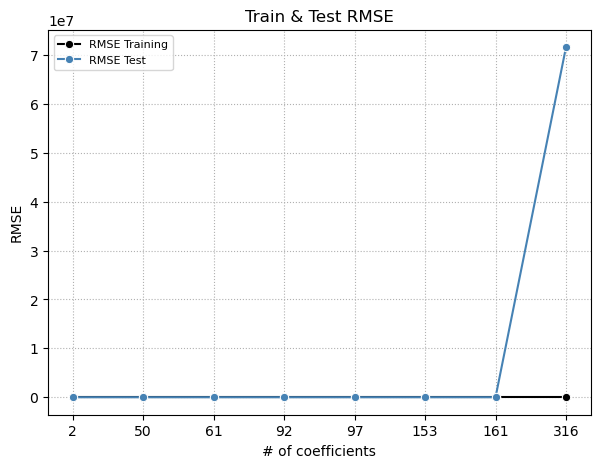

In [56]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    x = [str(x) for x in df_rmse_levels['nvars2']], 
    y = df_rmse_levels['value'], 
    hue = df_rmse_levels['var'], marker = 'o',
    palette = ['k', 'steelblue']
)
ax.set_title('Train & Test RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('# of coefficients')
ax.legend(fontsize = 8, title = None)
ax.grid(linestyle = ':')
plt.show();

## Lasso prediction

In [57]:
vars_model_8 = modellev8

In [58]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("price" + vars_model_8, df)

In [59]:
y

DesignMatrix with shape (7577, 1)
  price
     76
     70
     80
     57
     46
     41
    500
     55
     89
     74
    138
     35
     65
     46
     85
     90
    418
     29
     70
     97
     98
     75
     80
    164
     94
     65
     80
    129
     86
     74
  [7547 rows omitted]
  Terms:
    'price' (column 0)
  (to view full data, use np.asarray(this_obj))

In [60]:
X.shape

(7577, 847)

In [61]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = [i/100 for i in range(5, 100,5)]

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [62]:
lambdas

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [63]:
train_r_squared

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [64]:
X.shape[1]

847

In [65]:
import datetime

In [66]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha = i, random_state= 20250217) # In Python, Lasso's lambda is called alpha. Why?
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

Run:  0, lambda: 0.05, start: 2025-03-03 03:36:01
Run:  1, lambda: 0.10, start: 2025-03-03 03:36:48
Run:  2, lambda: 0.15, start: 2025-03-03 03:37:05
Run:  3, lambda: 0.20, start: 2025-03-03 03:37:17
Run:  4, lambda: 0.25, start: 2025-03-03 03:37:25
Run:  5, lambda: 0.30, start: 2025-03-03 03:37:33
Run:  6, lambda: 0.35, start: 2025-03-03 03:37:39
Run:  7, lambda: 0.40, start: 2025-03-03 03:37:45
Run:  8, lambda: 0.45, start: 2025-03-03 03:37:49
Run:  9, lambda: 0.50, start: 2025-03-03 03:37:54
Run: 10, lambda: 0.55, start: 2025-03-03 03:37:58
Run: 11, lambda: 0.60, start: 2025-03-03 03:38:01
Run: 12, lambda: 0.65, start: 2025-03-03 03:38:05
Run: 13, lambda: 0.70, start: 2025-03-03 03:38:09
Run: 14, lambda: 0.75, start: 2025-03-03 03:38:13
Run: 15, lambda: 0.80, start: 2025-03-03 03:38:16
Run: 16, lambda: 0.85, start: 2025-03-03 03:38:20
Run: 17, lambda: 0.90, start: 2025-03-03 03:38:23
Run: 18, lambda: 0.95, start: 2025-03-03 03:38:26


In [67]:
results

array([0.17376706, 0.37914862, 0.26856089, 0.14112576, 0.37538111])

In [68]:
r_squared_df = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

In [69]:
r_squared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lambda    38 non-null     float64
 1   variable  38 non-null     object 
 2   value     38 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.0+ KB


In [70]:
r_squared_df["variable"] = r_squared_df["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)

In [71]:
r_squared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lambda    38 non-null     float64 
 1   variable  38 non-null     category
 2   value     38 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 902.0 bytes


In [72]:
r_squared_df

,lambda,variable,value
0,0.05,$R^2$ Test set,0.247052
1,0.10,$R^2$ Test set,0.250502
2,0.15,$R^2$ Test set,0.251424
3,0.20,$R^2$ Test set,0.251761
4,0.25,$R^2$ Test set,0.251751
5,0.30,$R^2$ Test set,0.252837
6,0.35,$R^2$ Test set,0.253857
7,0.40,$R^2$ Test set,0.254439
8,0.45,$R^2$ Test set,0.254879
9,0.50,$R^2$ Test set,0.255290


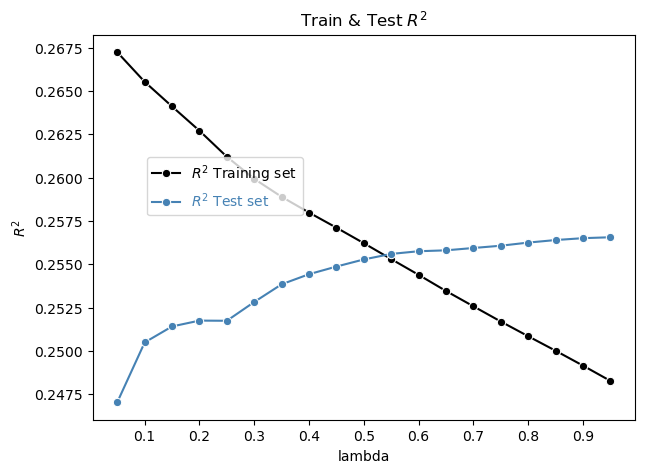

In [73]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    data = r_squared_df, 
    x = 'lambda', y = 'value', hue = 'variable', 
    palette = ['k', 'steelblue'],
    marker = 'o'
)
ax.set_title('Train & Test $R^2$')
ax.set_ylabel('$R^2$')
ax.set_xlabel('lambda')
ax.set_xticks(lambdas[1::2])
ax.legend(fontsize = 10, title = None, labelcolor = ['k', 'steelblue'], loc='upper right', bbox_to_anchor=(0.4, 0.7))
plt.show();

In [74]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    25.656927
lambda        0.950000
Name: 18, dtype: float64

In [75]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

Lasso(alpha=0.95)

In [76]:
y_train_pred = reg_best.predict(X_train)

In [77]:
from sklearn.metrics import mean_squared_error

In [78]:
rmse_Lasso_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {rmse_Lasso_train:.3f}")

Training RMSE: 91.708


In [79]:
y_test_pred = reg_best.predict(X_test)

In [80]:
rmse_Lasso_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {rmse_Lasso_test:.3f}")

Test RMSE: 92.472


In [81]:
reg_best.coef_[reg_best.coef_>0]

array([8.12251128e-01, 2.28958151e+01, 9.47142753e+00, 1.77146333e+01,
       7.25475256e+00, 8.73663757e-01, 7.18476372e+00, 6.45542604e+00,
       2.59725980e+00, 4.42351154e+00, 3.36896709e+00, 5.93424838e+00,
       6.18350578e-01, 5.43046314e-01, 3.79291227e-02, 1.31881823e+00,
       7.75118921e+00, 1.06784337e+00, 2.40451972e+00, 8.83242098e-01,
       1.69688905e-02, 2.30757760e-01, 1.00442517e+01, 1.27068776e+00,
       4.88331727e-01, 1.02634028e+00, 1.27957891e-01, 3.50866588e-03,
       2.61670580e-02, 6.04663837e-01, 1.21523453e-03, 1.03634543e+00,
       4.42056143e-02, 2.82649774e-06, 1.14784111e-02, 8.03824174e+00,
       2.34931198e-01, 1.97906782e+00, 5.52445520e-02, 3.27635541e-01,
       2.54489363e+00, 3.73526485e-01, 2.95663202e-03, 2.40583930e+00,
       6.36719052e-07, 4.37832803e-10, 2.65260155e+00, 7.75009902e-01,
       8.90398771e-02, 1.14325874e+00, 1.17298321e+00, 1.11799522e+00,
       2.51209401e+00, 1.39752166e+00])

In [82]:
print(reg_best.coef_)

[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  8.12251128e-01 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -1.93558378e-01 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -7.79121483e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [83]:
reg_best.get_params()

{'alpha': 0.95,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

## LASSO using `GridSearch`

In [84]:
from sklearn.metrics import mean_squared_error

print(f'{mean_squared_error(y_test, reg_best.predict(X_test)):,.2f}')

8,551.16


In [85]:
y,  X = patsy.dmatrices('price'+vars_model_8, df)

In [86]:
vars_model_8

'~accommodates+beds+property_type+room_type+n_days_since+flag_days_since+bathrooms+bedrooms+host_is_superhost+flag_reviews_per_month+number_of_reviews+review_scores_rating+flag_review_scores_rating+reviews_per_month+host_response_time+host_response_rate+host_acceptance_rate+host_has_profile_pic+host_identity_verified+n_accommodates2+n_days_since2+n_days_since3+host_acceptance_rate+neighbourhood_Avvocata+neighbourhood_Bagnoli+neighbourhood_Barra+neighbourhood_Chiaia+neighbourhood_Chiaiano+neighbourhood_Fuorigrotta+neighbourhood_Mercato+neighbourhood_Miano+neighbourhood_Montecalvario+neighbourhood_Pendino+neighbourhood_Pianura+neighbourhood_Piscinola+neighbourhood_Poggioreale+neighbourhood_Ponticelli+neighbourhood_Porto+neighbourhood_Posillipo+neighbourhood_San_Carlo_all_Arena+neighbourhood_San_Ferdinando+neighbourhood_San_Giovanni_a_Teduccio+neighbourhood_San_Giuseppe+neighbourhood_San_Lorenzo+neighbourhood_San_Pietro_a_Patierno+neighbourhood_Scampia+neighbourhood_Secondigliano+neighbou

In [87]:
X.shape

(7577, 847)

In [88]:
from sklearn.model_selection import GridSearchCV

In [89]:
%%time

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 20250217)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv = cv, verbose= 3) # control your output with the 'verbose' option
# perform the search
results = search.fit(X, y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5] END ......................alpha=0.05;, score=-62.691 total time=   2.3s
[CV 2/5] END ......................alpha=0.05;, score=-60.102 total time=   4.8s
[CV 3/5] END .....................alpha=0.05;, score=-107.308 total time=   2.4s
[CV 4/5] END .....................alpha=0.05;, score=-100.361 total time=   5.4s
[CV 5/5] END .....................alpha=0.05;, score=-123.617 total time=   1.8s
[CV 1/5] END .......................alpha=0.1;, score=-62.539 total time=   2.8s
[CV 2/5] END .......................alpha=0.1;, score=-58.759 total time=   1.9s
[CV 3/5] END ......................alpha=0.1;, score=-107.415 total time=   1.8s
[CV 4/5] END .......................alpha=0.1;, score=-99.722 total time=   2.7s
[CV 5/5] END ......................alpha=0.1;, score=-123.655 total time=   1.0s
[CV 1/5] END .......alpha=0.15000000000000002;, score=-62.504 total time=   0.7s
[CV 2/5] END .......alpha=0.15000000000000002;, 

In [90]:
print(f'RMSE: {(results.best_score_ * -1):,.3f}')

RMSE: 90.221


In [91]:
results.cv_results_['rank_test_score']

array([16,  8,  5,  2,  1,  3,  4,  6,  7,  9, 10, 11, 12, 13, 14, 15, 17,
       18, 19], dtype=int32)

In [92]:
grid

{'alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}

In [93]:
results.best_estimator_

Lasso(alpha=0.25)

In [94]:
model3_level = smf.ols('price'+modellev3, data=df_train).fit(cov_type='HC0')
model7_level = smf.ols('price'+modellev7, data=df_train).fit(cov_type='HC0')

In [95]:
# look at holdout RMSE
model7_level_work_predictions = pd.concat(
    [df_train["price"], model7_level.predict(df_train)],
    axis=1,
    keys=["price", "predicted"],
)

In [96]:
model7_level_work_predictions.tail()

,price,predicted
149,115.0,81.175969
791,120.0,127.367689
5778,93.0,40.954656
4383,70.0,72.985608
294,86.0,111.359543


In [97]:
model7_level_work_predictions = model7_level_work_predictions[~model7_level_work_predictions.isna().any(axis=1)]
model7_level_work_rmse = rmse(model7_level_work_predictions["price"], model7_level_work_predictions["predicted"], axis=0)

In [98]:
model7_level_work_rmse

85.624930289311

In [99]:
model7_level_holdout_predictions = pd.concat(
    [df_holdout["price"], model7_level.predict(df_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
model7_level_holdout_predictions = model7_level_holdout_predictions[~model7_level_holdout_predictions.isna().any(axis=1)]
model7_level_holdout_rmse = rmse(model7_level_holdout_predictions["price"], model7_level_holdout_predictions["predicted"], axis=0)
print(
    f"RMSE work:{round(model7_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{model7_level_holdout_rmse:.2f}",
)

RMSE work:85.62 	 RMSE holdout:105.57


In [100]:
Ylev=df_holdout['price']
"""meanY=Ylev.mean()
sdY=Ylev.std()
meanY_m2SE = meanY -1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p=Ylev.quantile(.05)
Y95p=Ylev.quantile(.95)"""

'meanY=Ylev.mean()\nsdY=Ylev.std()\nmeanY_m2SE = meanY -1.96 * sdY\nmeanY_p2SE = meanY + 1.96 * sdY\nY5p=Ylev.quantile(.05)\nY95p=Ylev.quantile(.95)'

In [101]:
model7_level.get_prediction(df_holdout).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,106.677042,5.265756,96.356350,116.997734,-63.944508,277.298592
1,71.756229,3.291606,65.304801,78.207658,-98.675040,242.187499
2,112.416435,10.742088,91.362330,133.470540,-59.189136,284.022006
3,148.271411,10.077530,128.519816,168.023006,-23.179230,319.722051
4,73.217666,6.563650,60.353148,86.082184,-97.576632,244.011965
...,...,...,...,...,...,...
2261,110.160078,6.223902,97.961454,122.358701,-60.585356,280.905511
2262,69.016233,7.492702,54.330806,83.701660,-101.924863,239.957329
2263,63.129819,14.393798,34.918494,91.341144,-109.500061,235.759699
2264,74.116778,11.891534,50.809800,97.423755,-97.779737,246.013292


In [102]:
# Create df frame with the real and predicted values
df_diagnostic = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.05)

df_ = pd.concat(
    [df_holdout["price"], model7_level.predict(df_holdout)],
    axis=1,
    keys=["price", "predicted"],
)

In [103]:
df_.isna().sum()

price          0
predicted    713
dtype: int64

In [104]:
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
df_diagnostic["Ylev"] = df_["price"]

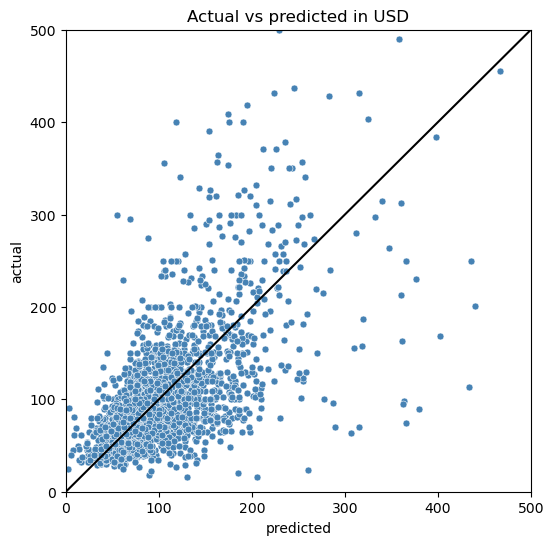

In [105]:
x = np.linspace(0, 500, df_diagnostic.shape[0])

plt.figure(figsize = (6,6))
ax = sns.scatterplot(
    data=df_diagnostic, x="mean", y="Ylev",
    s = 25, color = 'steelblue'
)
plt.plot(x,x, color = 'k')
ax.set_xlim(0,500)
ax.set_ylim(0,500)
ax.set_ylabel('actual')
ax.set_xlabel('predicted')
ax.set_title('Actual vs predicted in USD')
plt.show()

In [106]:
dt = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.2)
df_extra = pd.concat(
    [
        df_holdout["price"],
        df_holdout["accommodates"],
        model7_level.predict(df_holdout),
    ],
    axis=1,
    keys=["price", "accommodates", "predicted"],
)
df_extra = df_extra[~df_extra.isna().any(axis=1)].reset_index(drop=True)
dt["accommodates"] = df_extra["accommodates"]
dt["Ylev"] = df_extra["price"]
dt["elev"] = dt["Ylev"] - dt["mean"]

In [107]:
df_diagnostic = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.2)
df_ = pd.concat(
    [
        df_holdout["price"],
        df_holdout["accommodates"],
        model7_level.predict(df_holdout),
    ],
    axis=1,
    keys=["price", "accommodates", "predicted"],
)
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
df_diagnostic["accommodates"] = df_["accommodates"]
df_diagnostic["Ylev"] = df_["price"]
df_diagnostic["elev"] = df_diagnostic["Ylev"] - df_diagnostic["mean"]

In [108]:
predictionlev_holdout_summary = df_diagnostic.groupby(by=["accommodates"]).mean().reset_index()

In [109]:
predictionlev_holdout_summary

,accommodates,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,Ylev,elev
0,1,64.533317,14.616249,45.801839,83.264794,-49.611743,178.678376,62.259259,-2.274057
1,2,81.497730,10.142181,68.500002,94.495457,-30.887997,193.883456,84.985272,3.487543
2,3,84.178113,12.669870,67.941021,100.415204,-29.666147,198.022373,88.300366,4.122254
3,4,101.022820,10.119733,88.053860,113.991780,-11.664865,213.710505,108.372905,7.350085
4,5,118.631940,10.725305,104.886909,132.376970,5.801638,231.462242,126.250000,7.618060
5,6,148.590188,10.148367,135.584532,161.595844,36.220935,260.959441,147.428571,-1.161617
6,7,176.823416,15.417264,157.065398,196.581435,60.651344,292.995488,155.607143,-21.216273
7,8,210.893981,14.749643,191.991552,229.796409,96.271785,325.516177,201.847458,-9.046523
8,9,229.262664,13.438028,212.041138,246.484189,116.485057,342.040270,203.866667,-25.395997
9,10,282.643529,23.245199,252.853607,312.433450,165.167010,400.120047,304.230769,21.587241


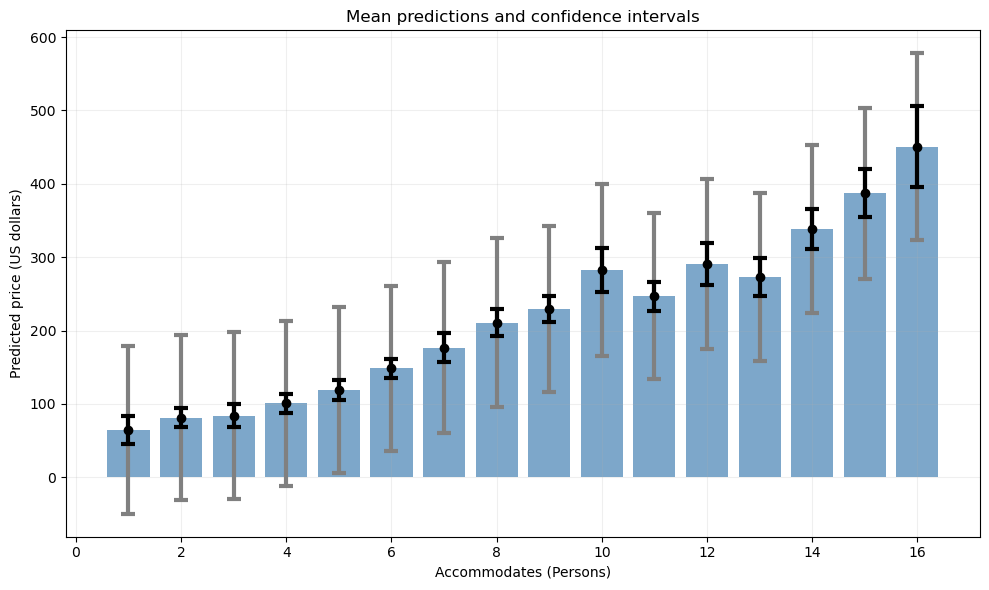

In [110]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for mean values
ax.bar(predictionlev_holdout_summary['accommodates'],
       predictionlev_holdout_summary['mean'],
       color='steelblue',
       alpha=0.7)

# Plot error bars for observations
ax.errorbar(predictionlev_holdout_summary['accommodates'],
            predictionlev_holdout_summary['mean'],
            yerr=[predictionlev_holdout_summary['mean'] - predictionlev_holdout_summary['obs_ci_lower'],
                  predictionlev_holdout_summary['obs_ci_upper'] - predictionlev_holdout_summary['mean']],
            fmt='none',
            color='grey',
            capsize=5,
            capthick=3,
            elinewidth=3)

# Plot error bars for means
ax.errorbar(predictionlev_holdout_summary['accommodates'],
            predictionlev_holdout_summary['mean'],
            yerr=[predictionlev_holdout_summary['mean'] - predictionlev_holdout_summary['mean_ci_lower'],
                  predictionlev_holdout_summary['mean_ci_upper'] - predictionlev_holdout_summary['mean']],
            fmt='bo',
            color='k',
            capsize=5,
            capthick=3,
            elinewidth=3)

# Customize axes and labels
ax.set_xlabel('Accommodates (Persons)')
ax.set_ylabel('Predicted price (US dollars)')
ax.set_title('Mean predictions and confidence intervals')

# Set style similar to theme_bw()
ax.grid(True, linestyle='-', alpha=0.2)
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_color('black')

# Adjust layout
plt.tight_layout()

# Return the plot


## Random Forest

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from patsy import dmatrices, dmatrix
import matplotlib.ticker as mtick

In [112]:
df.price.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).map('{:,.1f}'.format)

count    9,930.0
mean       113.4
std        122.0
min         13.0
1%          32.0
10%         52.0
25%         69.0
50%         90.0
75%        123.0
90%        180.0
99%        485.0
max      4,000.0
Name: price, dtype: object

In [113]:
df_train.shape, df_holdout.shape

((6951, 117), (2979, 117))

In [114]:
to_filter=df.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

neighbourhood_group_cleansed    9930
license                         4365
host_location                   3134
first_review                    2353
last_review                     2353
n_days_since                    2353
description                      212
has_availability                  35
bathrooms_text                    13
dtype: int64

In [115]:
# basic variables inc neighbourhood
basic_vars = [
    "accommodates",
    "beds",
    "n_days_since",
    "property_type",
    "room_type",
    "bathrooms",
    "bedrooms",
    "neighbourhood_cleansed",
]

# reviews
reviews = [
    "number_of_reviews",
    "flag_reviews_per_month",
    "review_scores_rating",
    "flag_review_scores_rating",
]

host = [
    "host_response_time", 
    "host_response_rate",
    "host_acceptance_rate",
    "host_has_profile_pic", 
    "host_identity_verified"]

# dummy variables
amenities = [col for col in df if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type",
    "room_type:property_type",
    "room_type:amenity_family",
    "amenity_air_conditioning:property_type",
    "amenity_pets:property_type"
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed",
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

In [116]:
categorical_columns = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]

In [117]:
print(df['neighbourhood_group_cleansed'].unique())

[nan]


In [118]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + host + amenities
predictors_E = basic_vars + reviews + host + amenities + X1 + X2

In [119]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), df_train, return_type='dataframe')
print("Training design matrix shape:", X.shape)  # e.g., (4810, 209)

# Build holdout design matrices from df_holdout
y_h, X_h = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
print("Holdout design matrix shape (before reindexing):", X_h.shape)  # e.g., (2083, 204)

# Convert the holdout design matrix into a DataFrame with the expected column names from training
X_h_df = pd.DataFrame(X_h, columns=X.design_info.column_names)

# Reindex the holdout DataFrame to ensure it has all columns from the training matrix, filling missing columns with 0
X_h_df = X_h_df.reindex(columns=X.columns, fill_value=0)
print("Holdout design matrix shape (after reindexing):", X_h_df.shape)  # Now (2083, 209)

Training design matrix shape: (5311, 97)
Holdout design matrix shape (before reindexing): (2266, 97)
Holdout design matrix shape (after reindexing): (2266, 97)


In [120]:
X.design_info.column_names

['Intercept',
 'property_type[T.Camper/RV]',
 'property_type[T.Casa particular]',
 'property_type[T.Castle]',
 'property_type[T.Dammuso]',
 'property_type[T.Dome]',
 'property_type[T.Entire bed and breakfast]',
 'property_type[T.Entire condo]',
 'property_type[T.Entire cottage]',
 'property_type[T.Entire guest suite]',
 'property_type[T.Entire guesthouse]',
 'property_type[T.Entire home]',
 'property_type[T.Entire home/apt]',
 'property_type[T.Entire loft]',
 'property_type[T.Entire place]',
 'property_type[T.Entire rental unit]',
 'property_type[T.Entire serviced apartment]',
 'property_type[T.Entire vacation home]',
 'property_type[T.Entire villa]',
 'property_type[T.Farm stay]',
 'property_type[T.Houseboat]',
 'property_type[T.Private room]',
 'property_type[T.Private room in bed and breakfast]',
 'property_type[T.Private room in boat]',
 'property_type[T.Private room in casa particular]',
 'property_type[T.Private room in condo]',
 'property_type[T.Private room in farm stay]',
 'pr

In [121]:
X.shape

(5311, 97)

In [122]:
import math

In [123]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 9.85.


In [124]:
rfr = RandomForestRegressor(random_state = 20250224)

In [125]:
tune_grid = {"max_features": [11, 13, 15, 17], "min_samples_leaf": [5, 10, 15]}
tune_grid

{'max_features': [11, 13, 15, 17], 'min_samples_leaf': [5, 10, 15]}

In [126]:
rf_random = GridSearchCV(
    estimator = rfr,
    param_grid = tune_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)

In [127]:
rf_model = rf_random.fit(X, y.values.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=11, min_samples_leaf=5;, score=-124.520 total time=   0.5s
[CV 2/5] END max_features=11, min_samples_leaf=5;, score=-54.640 total time=   0.4s
[CV 3/5] END max_features=11, min_samples_leaf=5;, score=-52.406 total time=   0.7s
[CV 4/5] END max_features=11, min_samples_leaf=5;, score=-116.307 total time=   0.4s
[CV 5/5] END max_features=11, min_samples_leaf=5;, score=-70.272 total time=   0.3s
[CV 1/5] END max_features=11, min_samples_leaf=10;, score=-124.838 total time=   0.2s
[CV 2/5] END max_features=11, min_samples_leaf=10;, score=-56.881 total time=   0.2s
[CV 3/5] END max_features=11, min_samples_leaf=10;, score=-52.430 total time=   0.2s
[CV 4/5] END max_features=11, min_samples_leaf=10;, score=-119.388 total time=   0.3s
[CV 5/5] END max_features=11, min_samples_leaf=10;, score=-76.208 total time=   0.4s
[CV 1/5] END max_features=11, min_samples_leaf=15;, score=-124.973 total time=   0.2s
[CV 

In [128]:
rf_model.cv_results_

{'mean_fit_time': array([0.41529927, 0.24798617, 0.19622364, 0.30102224, 0.31789026,
        0.37747664, 0.38483706, 0.27223234, 0.42844381, 0.3626399 ,
        0.26092782, 0.38767266]),
 'std_fit_time': array([0.1267978 , 0.0628046 , 0.01145305, 0.0681512 , 0.09867074,
        0.07698073, 0.13166237, 0.04637701, 0.09309508, 0.08733681,
        0.00311664, 0.14155064]),
 'mean_score_time': array([0.01661396, 0.01309819, 0.00824594, 0.01196756, 0.02826476,
        0.01297712, 0.01125278, 0.01139307, 0.01170793, 0.01174283,
        0.00894494, 0.01421595]),
 'std_score_time': array([0.00508633, 0.00830466, 0.00040423, 0.00269956, 0.0382625 ,
        0.00288063, 0.00130389, 0.00456243, 0.00176995, 0.00246517,
        0.0002107 , 0.00474774]),
 'param_max_features': masked_array(data=[11, 11, 11, 13, 13, 13, 15, 15, 15, 17, 17, 17],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value=999999),
 'para

In [129]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [130]:
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [131]:
df_rf_model_cv_results

,max features,min node size,RMSE
0,11,5,-83.629099
1,11,10,-85.949420
2,11,15,-86.692690
3,13,5,-83.532051
4,13,10,-85.539201
5,13,15,-86.277223
6,15,5,-83.776748
7,15,10,-85.266356
8,15,15,-85.809858
9,17,5,-83.018364


In [132]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
11,83.63,85.95,86.69
13,83.53,85.54,86.28
15,83.78,85.27,85.81
17,83.02,84.67,85.68


In [133]:
rmse_rf_train = - rf_model.best_score_
rmse_rf_train

83.01836416198721

In [134]:
y_train_pred_rf = rf_model.best_estimator_.predict(X)
rmse_rf_train = np.sqrt(mean_squared_error(y, y_train_pred_rf))
print(f"RF Training RMSE: {rmse_rf_train:.3f}")

RF Training RMSE: 76.709


In [135]:
rf_model.best_params_

{'max_features': 17, 'min_samples_leaf': 5}

In [136]:
rf_model.best_estimator_

RandomForestRegressor(max_features=17, min_samples_leaf=5,
                      random_state=20250224)

In [137]:
pred = rf_model.predict(X_h_df)

In [138]:
from statsmodels.tools.eval_measures import rmse

In [139]:
rmse(y_test, pred)

array([107.40066893, 119.54526002, 107.60962386, ..., 110.10900821,
       109.06815071, 111.8456338 ])

In [140]:
rmse_rf_hold = mean_squared_error(y_h, pred, squared=False)
rmse_rf_hold

103.25341846933343

In [141]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.72830541e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.31097031e-02,
       0.00000000e+00, 1.97232788e-04, 0.00000000e+00, 8.43232184e-03,
       3.57261608e-02, 5.08027663e-04, 2.96592633e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.33332155e-03, 0.00000000e+00,
       0.00000000e+00, 2.37868353e-03, 0.00000000e+00, 2.90935855e-05,
       1.87036554e-06, 5.54851274e-05, 0.00000000e+00, 0.00000000e+00,
       3.11385240e-03, 6.02229157e-05, 0.00000000e+00, 0.00000000e+00,
       9.95651271e-06, 0.00000000e+00, 0.00000000e+00, 1.09954362e-04,
       6.59199219e-04, 0.00000000e+00, 0.00000000e+00, 1.63606365e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.92587515e-04, 1.20256269e-04,
       1.00818087e-02, 1.29569978e-05, 2.06709518e-03, 9.32891296e-06,
      

In [142]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Camper/RV],0.000000
property_type[T.Casa particular],0.000000
property_type[T.Castle],0.000000
property_type[T.Dammuso],0.000000
...,...
host_response_time,0.026813
host_response_rate,0.009749
host_acceptance_rate,0.027127
host_has_profile_pic,0.001499


In [143]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [144]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,20.3%,20.3%
1,bathrooms,17.7%,38.0%
2,bedrooms,15.2%,53.3%
3,n_days_since,9.9%,63.2%
4,beds,5.9%,69.1%
5,number_of_reviews,5.6%,74.6%
6,review_scores_rating,5.1%,79.8%
7,property_type[T.Entire serviced apartment],3.6%,83.4%
8,host_acceptance_rate,2.7%,86.1%
9,host_response_time,2.7%,88.8%


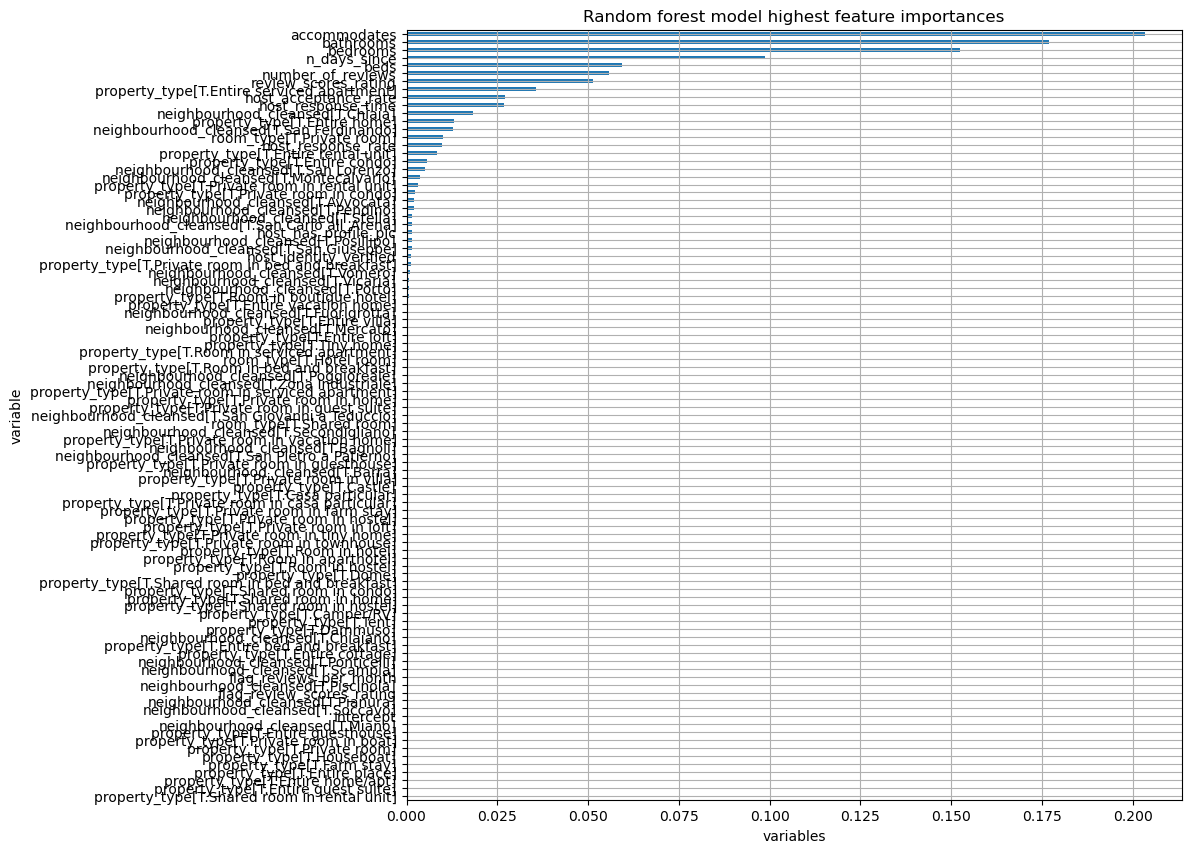

In [145]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [146]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

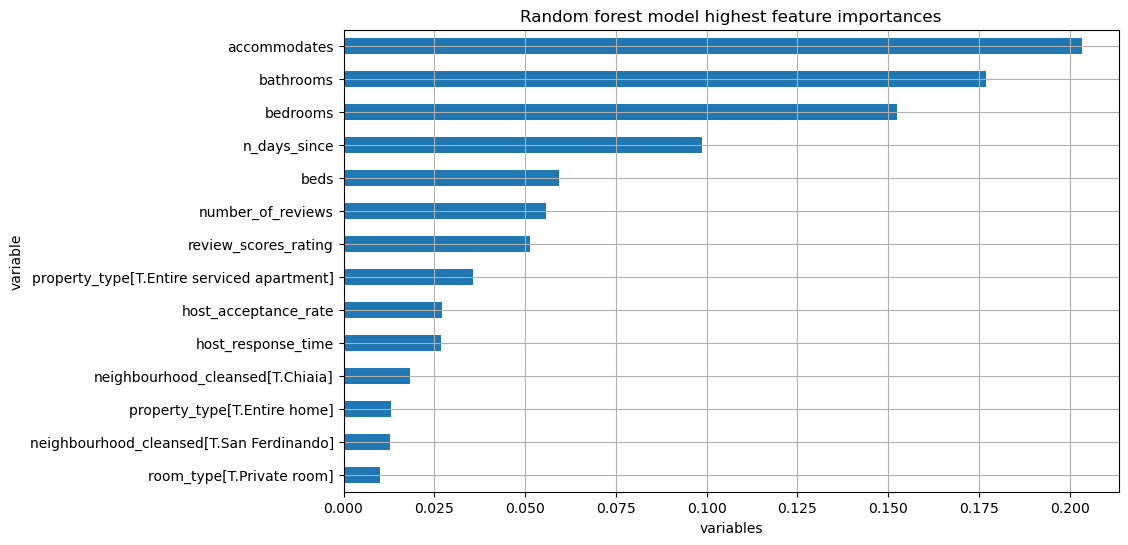

In [147]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

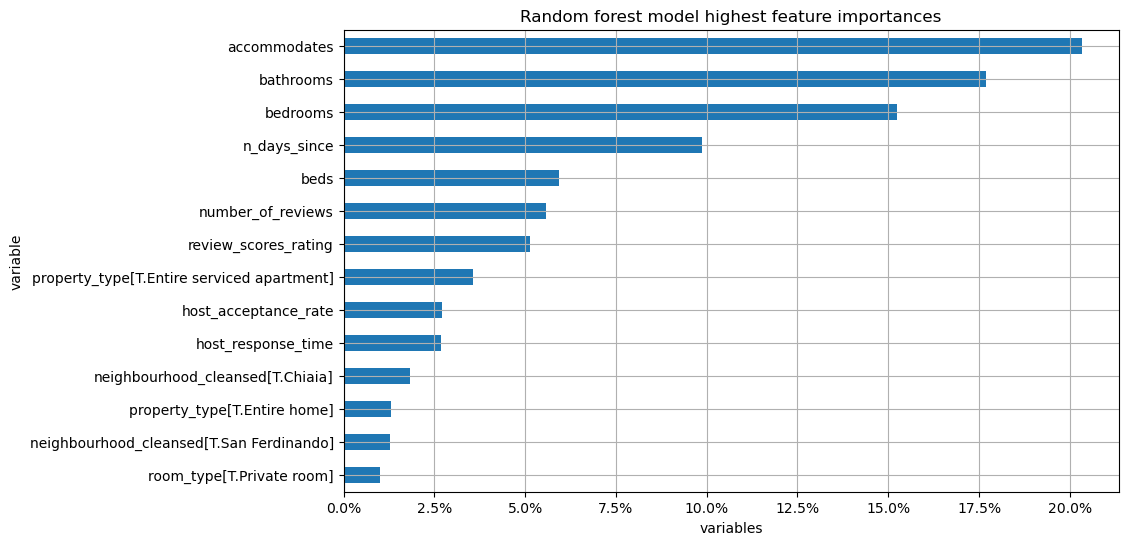

In [148]:
ax = df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh',
          x = 'variable', 
          y = 'imp',
          figsize = (10,6), 
          grid = True,
          title = 'Random forest model highest feature importances',
          xlabel = 'variables', 
          legend = False)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

In [149]:
categorical_columns = [
    "property_type",
    "room_type",
    "neighbourhood_cleansed",
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [150]:
numerical_columns

['accommodates',
 'beds',
 'n_days_since',
 'bathrooms',
 'bedrooms',
 'number_of_reviews',
 'flag_reviews_per_month',
 'review_scores_rating',
 'flag_review_scores_rating',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_identity_verified']

In [151]:
categorical_columns

['property_type', 'room_type', 'neighbourhood_cleansed']

In [152]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [153]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean"))
])

# Create a categorical pipeline using OneHotEncoder (which can handle missing values by ignoring unknowns)
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# Combine numerical and categorical transformers in a ColumnTransformer
preprocessing = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numerical_columns),
        ("cat", cat_pipeline, categorical_columns)
    ]
)

# Create the full pipeline, using your best RandomForest model from tuning:
rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessing), 
        ("regressor", rf_model.best_estimator_)  # your tuned RF model
    ]
)

# Fit the pipeline on the training data
rf_pipeline.fit(df_train[predictors_2], df_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['accommodates', 'beds',
                                                   'n_days_since', 'bathrooms',
                                                   'bedrooms',
                                                   'number_of_reviews',
                                                   'flag_reviews_per_month',
                                                   'review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'host_response_time',
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'neighbourhood_cleansed'])])),
                ('regressor',
                 RandomForestRegressor(max_features=17, min_samples_leaf=5,
                                       random_state=20250224))])

In [154]:
%%time
result = permutation_importance(
    rf_pipeline,
    df_holdout[predictors_2],
    df_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: user 5.54 s, sys: 76.4 ms, total: 5.62 s
Wall time: 6.62 s


In [155]:
pd.DataFrame(
        result.importances_mean,
        df_train[predictors_2].columns)

,0
accommodates,0.051661
beds,-0.003463
n_days_since,0.014309
property_type,0.003324
room_type,0.005403
bathrooms,0.023523
bedrooms,0.018844
neighbourhood_cleansed,0.025944
number_of_reviews,0.003296
flag_reviews_per_month,-0.001754


In [156]:
grouped = [
    "property_type",
    "room_type",
    "bathrooms",
    "n_days_since",
    "accommodates",
    "beds",
    "neighbourhood_cleansed",
    "bedrooms",
    'number_of_reviews',
    'review_scores_rating',
    'host_response_rate',
    'host_acceptance_rate',
]

In [157]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        df_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [158]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,5.2%,5.2%
1,neighbourhood_cleansed,2.6%,7.8%
2,bathrooms,2.4%,10.1%
3,bedrooms,1.9%,12.0%
4,review_scores_rating,1.7%,13.7%
5,n_days_since,1.4%,15.1%
6,room_type,0.5%,15.7%
7,property_type,0.3%,16.0%
8,number_of_reviews,0.3%,16.3%
9,host_response_rate,0.2%,16.6%


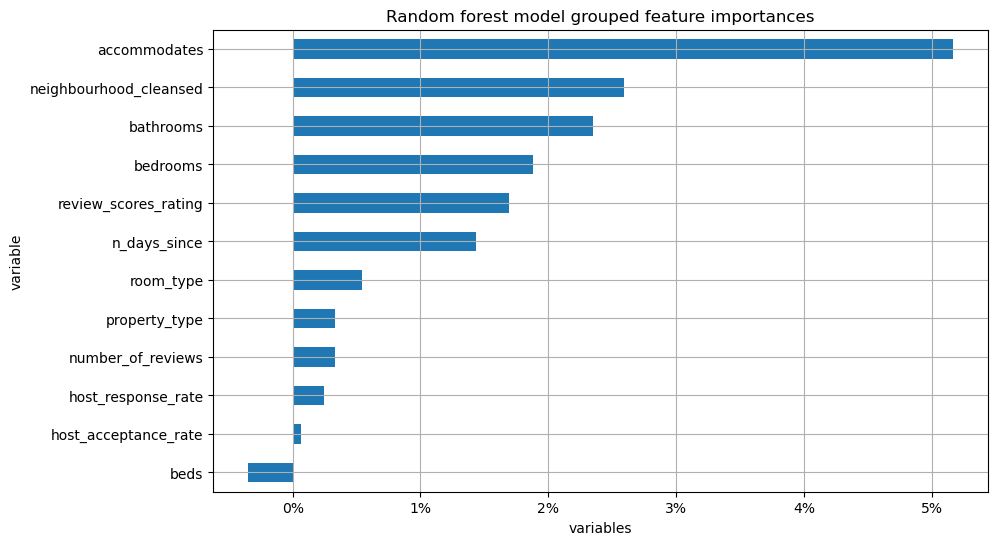

In [159]:
ax = df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         )
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals = 0));

In [160]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        df_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,accommodates,0.051661,0.203239
1,neighbourhood_cleansed,0.025944,0.380275
2,bathrooms,0.023523,0.532705
3,bedrooms,0.018844,0.631525
4,review_scores_rating,0.016943,0.690869
5,n_days_since,0.014309,0.746497
6,room_type,0.005403,0.797859
7,host_response_time,0.004388,0.833585
8,property_type,0.003324,0.860712
9,number_of_reviews,0.003296,0.887525


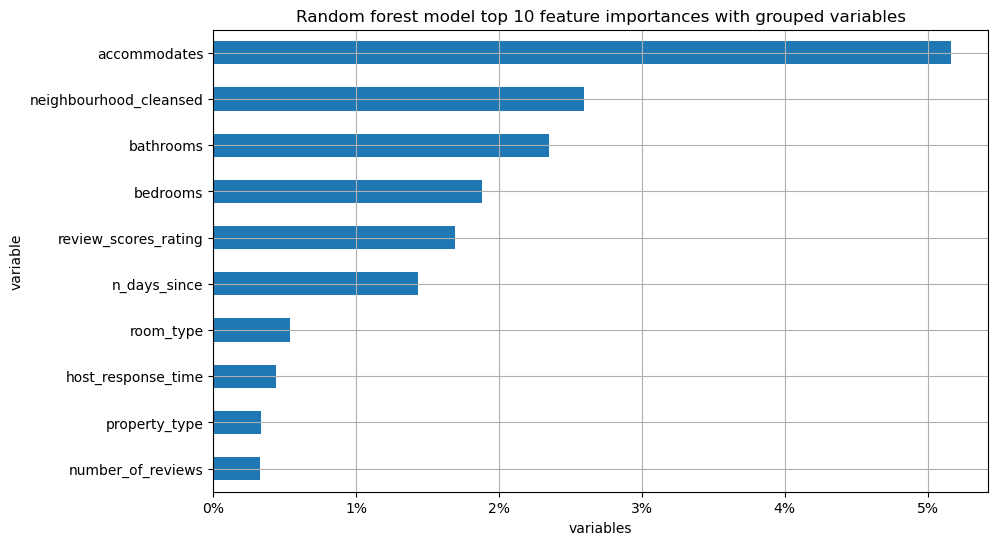

In [161]:
ax = df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         )
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals = 0));

In [162]:
accomodates_pdp = partial_dependence(
    rf_pipeline, df_holdout[predictors_2], ["accommodates"], kind="average"
)

In [163]:
accomodates_pdp

{'grid_values': [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])],
 'average': array([[ 99.52494467, 102.96391745, 106.61477088, 113.87417718,
         117.82655828, 136.64005519, 139.17399179, 173.1145381 ,
         173.03671005, 177.95726267, 178.04043744, 178.06901585,
         181.4549576 , 193.84065597, 219.1482915 , 227.21166135]])}

In [164]:
type(accomodates_pdp)

sklearn.utils._bunch.Bunch

In [165]:
pd.DataFrame({
    'number of accommodates': accomodates_pdp['grid_values'][0],
    'average price': accomodates_pdp['average'][0]
})

,number of accommodates,average price
0,1,99.524945
1,2,102.963917
2,3,106.614771
3,4,113.874177
4,5,117.826558
5,6,136.640055
6,7,139.173992
7,8,173.114538
8,9,173.036710
9,10,177.957263


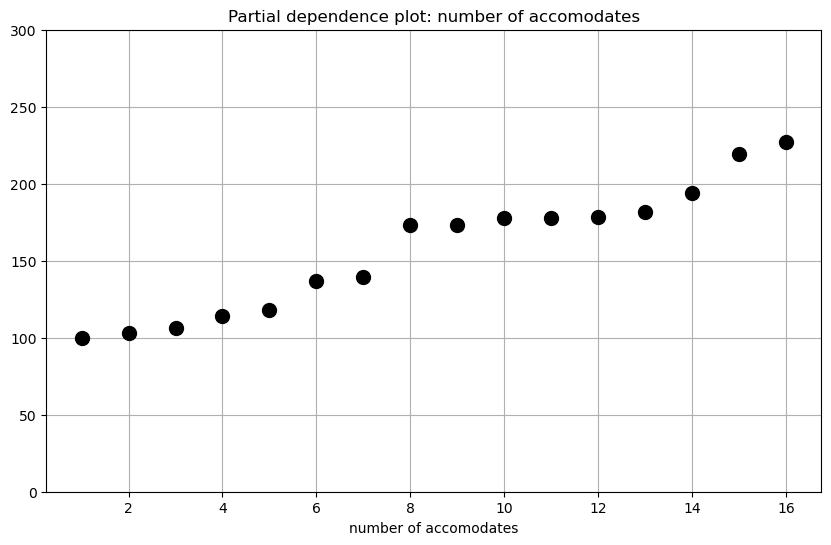

In [166]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['grid_values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 300), 
    title = 'Partial dependence plot: number of accomodates'
);

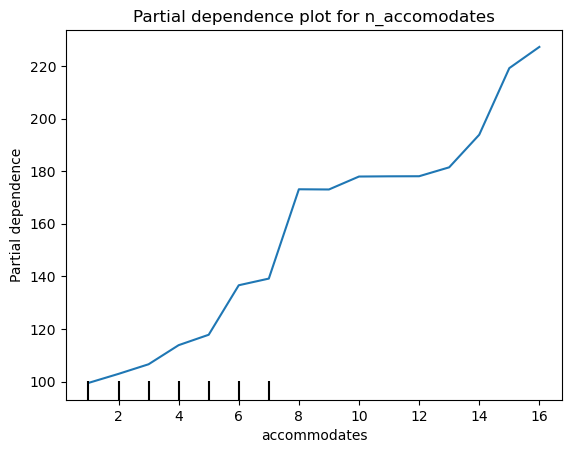

In [167]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = df_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 7, num=7)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

In [168]:
roomtype_pdp = partial_dependence(
    rf_pipeline, df_holdout[predictors_2], ["room_type"], kind="average"
)

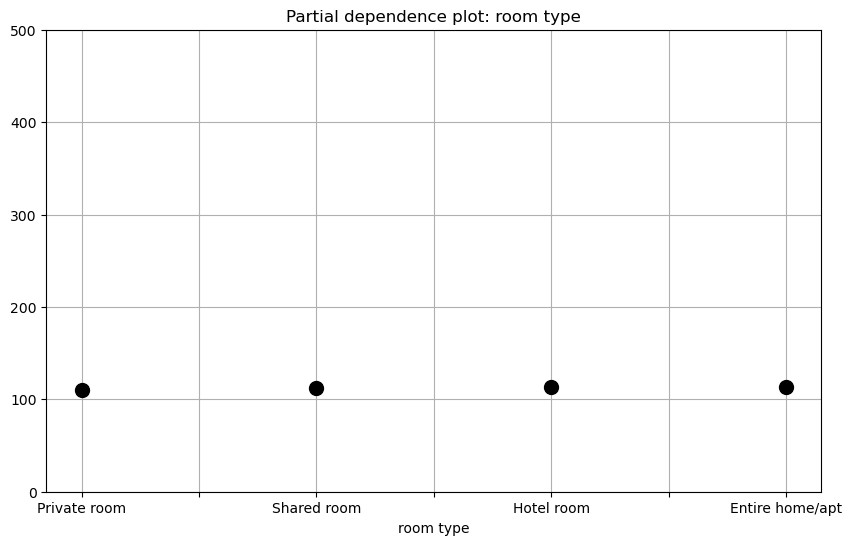

In [169]:
pd.DataFrame(
    {'room type': roomtype_pdp['grid_values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 500), 
    title = 'Partial dependence plot: room type'
);

In [170]:
df_holdout_w_prediction = df_holdout.assign(
    predicted_price=rf_pipeline.predict(df_holdout[predictors_2])
)

In [171]:
df_holdout_w_prediction['is_low_size'] = df_holdout_w_prediction.accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

In [172]:
df_holdout_w_prediction.iloc[0:5, -5:]

,n_accommodates2,n_days_since2,n_days_since3,predicted_price,is_low_size
5268,0,0,0,100.604031,large apt
1668,1,0,0,61.652081,small apt
2681,0,0,0,114.398378,large apt
4141,0,0,0,115.939243,large apt
10478,1,0,0,110.860951,small apt


In [173]:
df_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    107.687762
small apt     72.341357
dtype: float64

In [174]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)
    )

In [175]:
# cheaper or more expensive flats - not used in book
grouped_object = df_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [176]:
accom_subset

,rmse,mean_price,rmse_normalized
is_low_size,,,
large apt,117.86,133.71,0.88
small apt,65.75,88.91,0.74


In [177]:
unique_neighbourhoods = df['neighbourhood_cleansed'].unique()
print(unique_neighbourhoods)

['San Lorenzo' 'Chiaia' 'San Giuseppe' 'Vomero' 'Porto' 'Montecalvario'
 'Avvocata' 'Pendino' 'Stella' 'Posillipo' 'San Ferdinando' 'Arenella'
 'San Carlo all_Arena' 'Ponticelli' 'Mercato' 'Fuorigrotta' 'Vicaria'
 'Zona Industriale' 'Poggioreale' 'Bagnoli' 'Chiaiano' 'Piscinola' 'Barra'
 'San Pietro a Patierno' 'Secondigliano' 'San Giovanni a Teduccio'
 'Soccavo' 'Pianura' 'Scampia' 'Miano']


In [178]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            df_holdout_w_prediction.price,
            df_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        df_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout.style.format({'rmse': '{:.1f}', 'mean_price': '{:.1f}', 'rmse_normalized': '{:.2f}'})

,rmse,mean_price,rmse_normalized
Total,97.2,112.9,0.86


## CART

In [179]:
from sklearn.tree import DecisionTreeRegressor

In [180]:
y, X = patsy.dmatrices("price ~ " + " + ".join(predictors_2), df_train, return_type='dataframe')

In [181]:
X.shape

(5311, 97)

In [182]:
cart_model = DecisionTreeRegressor(random_state=20250224)

In [183]:
path = cart_model.cost_complexity_pruning_path(X, y.values.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [184]:
ccp_alphas

array([0.00000000e+00, 3.13814097e-05, 9.41442290e-05, ...,
       7.68738280e+02, 1.18020791e+03, 1.34795823e+03])

In [185]:
ccp_alphas.shape

(4366,)

In [186]:
impurities

array([1.83581246e-01, 1.83612628e-01, 1.83706772e-01, ...,
       8.27899332e+03, 9.45920123e+03, 1.08071595e+04])

In [187]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv = 5,
    scoring="neg_root_mean_squared_error",
    verbose = 3,
)
cart_model_cv.fit(X, y.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ccp_alpha=9.414422895876483e-05;, score=-147.688 total time=   0.1s
[CV 2/5] END ccp_alpha=9.414422895876483e-05;, score=-100.435 total time=   0.1s
[CV 3/5] END .ccp_alpha=9.414422895876483e-05;, score=-79.725 total time=   0.1s
[CV 4/5] END ccp_alpha=9.414422895876483e-05;, score=-118.675 total time=   0.1s
[CV 5/5] END ccp_alpha=9.414422895876483e-05;, score=-165.429 total time=   0.1s
[CV 1/5] END ..ccp_alpha=0.06529843720579948;, score=-147.375 total time=   0.1s
[CV 2/5] END ..ccp_alpha=0.06529843720579948;, score=-100.186 total time=   0.1s
[CV 3/5] END ...ccp_alpha=0.06529843720579948;, score=-79.533 total time=   0.1s
[CV 4/5] END ..ccp_alpha=0.06529843720579948;, score=-118.428 total time=   0.1s
[CV 5/5] END ..ccp_alpha=0.06529843720579948;, score=-165.246 total time=   0.3s
[CV 1/5] END .ccp_alpha=0.045346136948470464;, score=-147.625 total time=   0.1s
[CV 2/5] END .ccp_alpha=0.045346136948470464;, s

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20250224),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 3.13814097e-05, 9.41442290e-05, ...,
       7.68738280e+02, 1.18020791e+03, 1.34795823e+03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [188]:
best_cart = cart_model_cv.best_estimator_

In [189]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

120.97325729141718

In [190]:
y_train_pred = best_cart.predict(X)
rmse_cart_train = np.sqrt(mean_squared_error(y, y_train_pred))
print(f"Training RMSE: {rmse_cart_train:.3f}")

# --- Compute Holdout RMSE ---
# Assume you have a holdout set with design matrices built the same way as X.
# For example, using:
# y_holdout, X_holdout = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
# And ensuring that X_holdout is reindexed to have the same columns as X.
y_holdout, X_holdout = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
X_holdout = X_holdout.reindex(columns=X.columns, fill_value=0)

y_holdout_pred = best_cart.predict(X_holdout)
rmse_cart_holdout = np.sqrt(mean_squared_error(y_holdout, y_holdout_pred))
print(f"Holdout RMSE: {rmse_cart_holdout:.3f}")

Training RMSE: 20.373
Holdout RMSE: 119.530


## GBM Boosting

In [191]:
from sklearn.ensemble import GradientBoostingRegressor

In [192]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [193]:
categorical_columns = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [194]:
tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features=10, random_state=42)
gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

# Define categorical and numerical columns:
categorical_columns = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]
# predictors_2 should already be defined; now numerical_columns are those in predictors_2 not in categorical_columns.
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

# Create a numerical pipeline that imputes missing values:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean"))
])

# Create a categorical pipeline:
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# Combine them with ColumnTransformer:
preprocessing = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, categorical_columns),
        ("num", num_pipeline, numerical_columns),
    ]
)

# Build the complete pipeline with boosting:
gbm_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessing),
        ("regressor", gbm_model_cv)
    ],
    verbose=True
)

# Fit the pipeline on your training data:
gbm_pipe.fit(df_train[list(predictors_2)], df_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 3/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 2/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 5/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 3/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 2/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 4/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 1/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 1/5; 1/4] END max_depth=5, n_estimators=200;, score=-117.489 total time=   0.6s
[CV 4/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 2/5; 1/4] END max_depth=5, n_estimators=200;, score=-135.041 total time=   0.5s
[CV 5/5; 2/4] START max_depth=5, n_estimato

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'neighbourhood_cleansed']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['accommodates', 'beds',
                                                   'n_days_since', 'bathrooms',
                                                   'bedrooms',
                                                   'number_of_reviews',
                                                   'flag_reviews_per_month...
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [195]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=5, max_features=10, min_samples_split=20,
                          n_estimators=200, random_state=42)

In [196]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [197]:
gbm_rmse

109.25448175081821

In [198]:
y_train_pred = gbm_pipe.predict(df_train[list(predictors_2)])
rmse_gbm_train = np.sqrt(mean_squared_error(df_train.price, y_train_pred))
print(f"GBM Train RMSE: {rmse_gbm_train:.3f}")

# Predict on the holdout set using the pipeline
y_holdout_pred = gbm_pipe.predict(df_holdout[list(predictors_2)])
rmse_gbm_holdout = np.sqrt(mean_squared_error(df_holdout.price, y_holdout_pred))
print(f"GBM Holdout RMSE: {rmse_gbm_holdout:.3f}")

GBM Train RMSE: 74.364
GBM Holdout RMSE: 103.886


## MLP Regressor

In [199]:
from sklearn.neural_network import MLPRegressor

# Initialize and train MLP Neural Network
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1500, random_state=20250301)
mlp_model.fit(X, y)

# Predictions & RMSE
y_pred_mlp = mlp_model.predict(X)
mlp_train_rmse = np.sqrt(mean_squared_error(y, y_pred_mlp))

print("MLP Neural Network RMSE:", mlp_train_rmse)

MLP Neural Network RMSE: 87.77864812841436


In [200]:
y_h, X_holdout = patsy.dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
X_holdout = X_holdout.reindex(columns=X.columns, fill_value=0)

In [201]:
y_pred_mlp_holdout = mlp_model.predict(X_holdout)
mlp_rmse_holdout = np.sqrt(mean_squared_error(y_h, y_pred_mlp_holdout))
print(f"MLP Holdout RMSE: {mlp_rmse_holdout:.3f}")

MLP Holdout RMSE: 113.229


## Cat Boost Regressor

In [202]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Assume 'df' is your cleaned DataFrame and predictors_2 is defined as:
# (basic_vars + reviews + host + amenities)
# and categorical_columns is defined as:
# ['property_type', 'room_type', 'neighbourhood_cleansed']

# For CatBoost, we want the categorical features as strings.
df_cat = df.copy()
for col in ['property_type', 'room_type', 'neighbourhood_cleansed']:
    df_cat[col] = df_cat[col].astype(str)

# Define X and y
X = df_cat[predictors_2]
y = df_cat['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical feature indices (CatBoost accepts these indices directly)
# predictors_2 should be the full list of predictor column names.
cat_features = [i for i, col in enumerate(predictors_2) if col in ['property_type', 'room_type', 'neighbourhood_cleansed']]

# Initialize and train CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations=500,       # you can tune this
    learning_rate=0.1,      # you can tune this
    depth=6,                # you can tune this
    random_seed=42,
    verbose=100             # shows progress every 100 iterations
)

# Fit the model, specifying which features are categorical
catboost_model.fit(X_train, y_train, cat_features=cat_features)

# Predict on the test set
y_pred = catboost_model.predict(X_test)

# Calculate RMSE
CatBootrmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("CatBoost RMSE:", rmse)

0:	learn: 113.1448205	total: 64.3ms	remaining: 32.1s
100:	learn: 84.8793081	total: 338ms	remaining: 1.33s
200:	learn: 79.3188997	total: 573ms	remaining: 852ms
300:	learn: 74.9263148	total: 797ms	remaining: 527ms
400:	learn: 70.9272037	total: 1.03s	remaining: 254ms
499:	learn: 67.8194938	total: 1.26s	remaining: 0us
CatBoost RMSE: <function rmse at 0x30a96a3e0>


In [203]:
# Predict on the training set
y_pred_train = catboost_model.predict(X_train)

# Calculate RMSE for the training set
catboot_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("CatBoost Training RMSE:", catboot_rmse_train)

CatBoost Training RMSE: 73.47822578018993


In [204]:
X_holdout = df_holdout[predictors_2]
y_holdout = df_holdout["price"]

# Predict using your fitted CatBoost model
y_holdout_pred = catboost_model.predict(X_holdout)

# Calculate RMSE on the holdout data
catboot_holdout_rmse = np.sqrt(mean_squared_error(y_holdout, y_holdout_pred))
print("Holdout RMSE:", catboot_holdout_rmse)

Holdout RMSE: 86.21528313435964


                      Feature  Importance
0                accommodates   13.421341
7      neighbourhood_cleansed   11.550763
5                   bathrooms   11.448977
3               property_type    9.098876
2                n_days_since    7.536998
13         host_response_rate    6.990498
6                    bedrooms    6.958215
1                        beds    5.164832
14       host_acceptance_rate    5.097500
8           number_of_reviews    5.063855
10       review_scores_rating    5.012511
12         host_response_time    4.140902
4                   room_type    4.121388
15       host_has_profile_pic    2.109156
9      flag_reviews_per_month    0.939551
16     host_identity_verified    0.938908
11  flag_review_scores_rating    0.405729


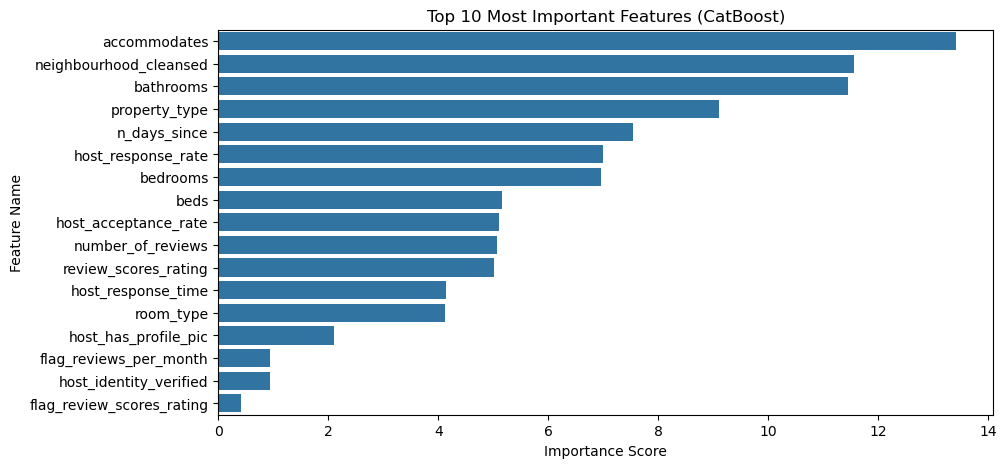

In [205]:
feature_importance = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Create a DataFrame for sorting and visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)  # Get top 10

# Display the top 10 features
print(importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Top 10 Most Important Features (CatBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

## Results

In [206]:
rmse_results = pd.DataFrame({
    "Model": [
        "OLS", 
        "Lasso", 
        "Lasso (GridSearchCV)",
        "Random Forest",
        "CART",
        "GBM Boosting",
        "MLP Regressor",
        "CatBoost Regressor"
    ],
    "Training RMSE": [
        model2_train_rmse,         # OLS training RMSE
        rmse_Lasso_train,          # Lasso training RMSE
        model7_level_work_rmse,    # Lasso (GridSearchCV) training RMSE
        rmse_rf_train,             # Random Forest training RMSE
        rmse_cart_train,           # CART training RMSE
        rmse_gbm_train,            # GBM training RMSE
        mlp_train_rmse,             # MLP training RMSE
        catboot_rmse_train         # CatBoost training RMSE
    ],
    "Holdout RMSE": [
        model2_test_rmse,          # OLS test RMSE from CV folds
        rmse_Lasso_test,           # Lasso test RMSE
        model7_level_holdout_rmse, # Lasso (GridSearchCV) holdout RMSE
        rmse_rf_hold,             # Random Forest holdout RMSE
        rmse_cart_holdout,         # CART holdout RMSE
        rmse_gbm_holdout,          # GBM holdout RMSE
        mlp_rmse_holdout,          # MLP holdout RMSE
        catboot_holdout_rmse       # CatBoost holdout RMSE
    ]
})

# Print the results table
print(rmse_results)

                  Model  Training RMSE  Holdout RMSE
0                   OLS      92.568161     91.396249
1                 Lasso      91.707899     92.472488
2  Lasso (GridSearchCV)      85.624930    105.570629
3         Random Forest      76.708829    103.253418
4                  CART      20.373133    119.529932
5          GBM Boosting      74.364406    103.885723
6         MLP Regressor      87.778648    113.229255
7    CatBoost Regressor      73.478226     86.215283


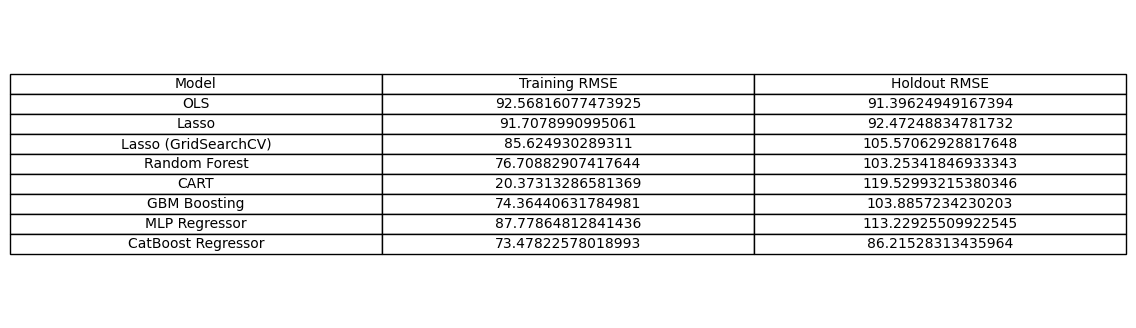

In [207]:
fig, ax = plt.subplots(figsize=(12, 4))  # adjust the size as needed

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table from the DataFrame
table = ax.table(
    cellText=rmse_results.values,
    colLabels=rmse_results.columns,
    cellLoc='center',
    loc='center'
)

# Optionally, adjust the table properties for a better look:
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save the figure as an image file
plt.savefig("rmse_results_table.png", bbox_inches='tight', dpi=300)
plt.show()

## The best is Catboost Regressor